In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import git
import os

# Get git repository root
repo = git.Repo(".", search_parent_directories = True)
# Update notebook working dir to repository root
os.chdir(repo.working_tree_dir)

with open("python/plot_all_events.py", "r") as file:
    exec(file.read())

with open("python/action_potential_methods.py", "r") as file:
    exec(file.read())

# Detection of action potentials

In [2]:
samples = pd.read_csv("sample_sheet.csv")
sample = samples[ samples["SID"] == "W4_C4" ].iloc[0]
sample

SID              W4_C4
AnimalID            W4
CellName            C4
Region           M1_L5
Date        2019 12 17
Depth       649.973117
Count              660
Location         W4/C4
Cortex              M1
Layer               L5
Name: 38, dtype: object

In [3]:
data = pd.read_pickle(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/vm/filter.pkl")
channels = data.ch_names

In [4]:
signal = data.get_data()[4, :]
time = data.times

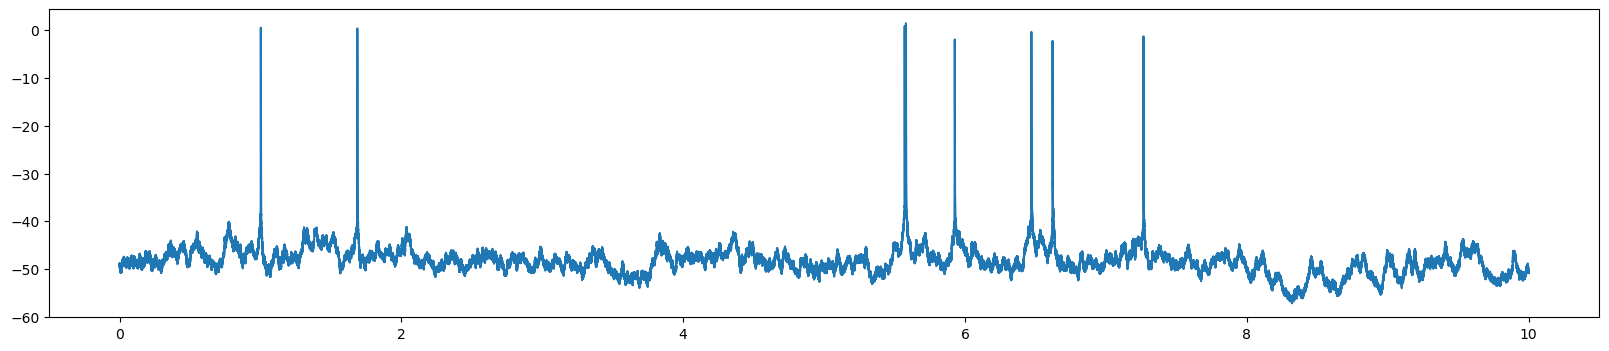

In [5]:
plt.figure(figsize = (20, 4))
plt.plot(time, signal)
plt.show()

In [6]:
differential = np.diff(signal)

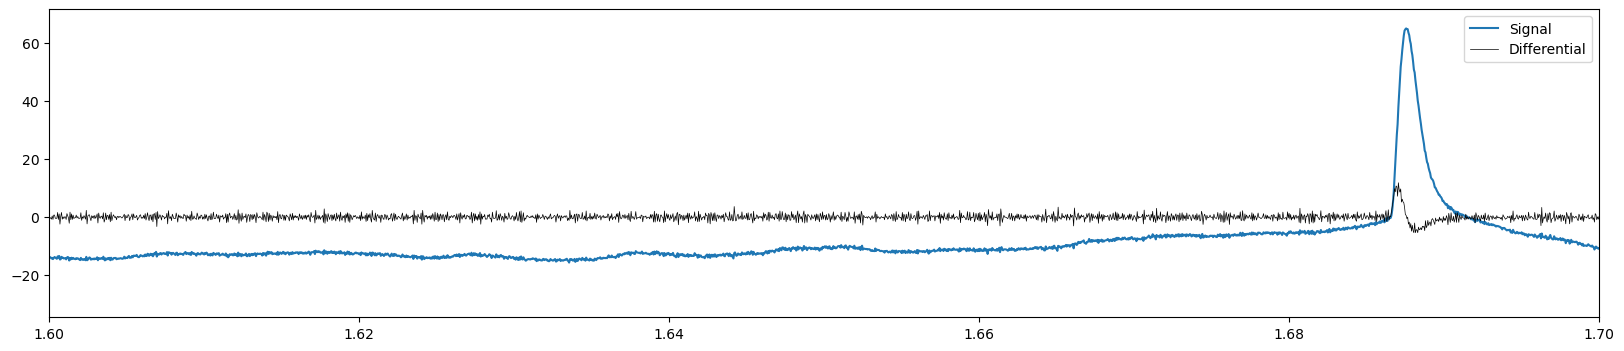

In [7]:
plt.figure(figsize = (20, 4))
plt.plot(time, ((signal - np.mean(signal)) / np.std(signal) - 3) * 5, label = "Signal")
plt.plot(time[1:], (differential - np.mean(differential)) / np.std(differential), linewidth = 0.5, c = "black", label = "Differential")
plt.xlim(1.6, 1.7)
plt.legend()
plt.show()

In [8]:
aps = find_ap(signal, time, threshold = 1.5)
ap = aps.iloc[0]

start = round(ap["EventStart"])
end = round(ap["EventEnd"])
startTime = round(ap["Start"], 2) - 0.05
endTime = round(ap["End"], 2) + 0.05

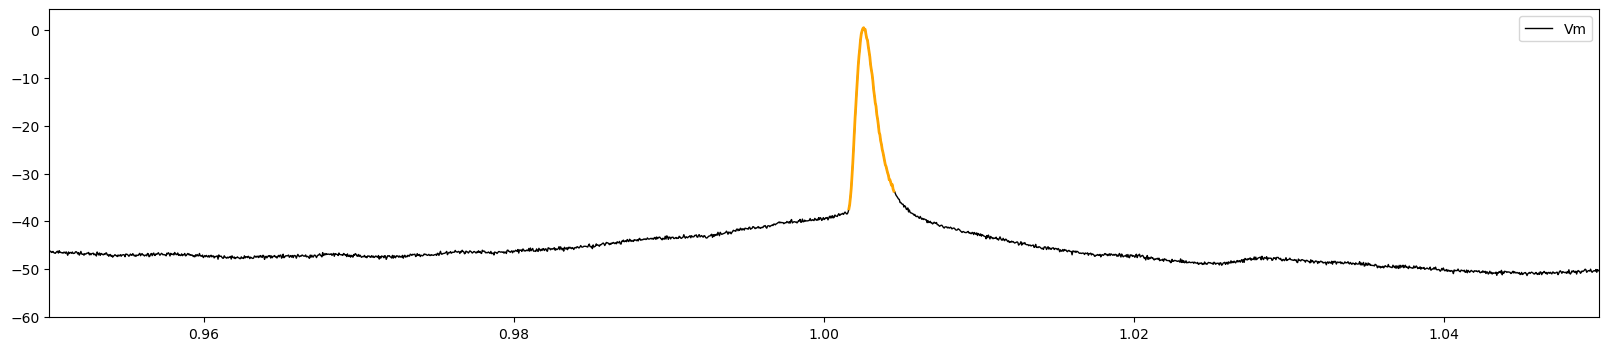

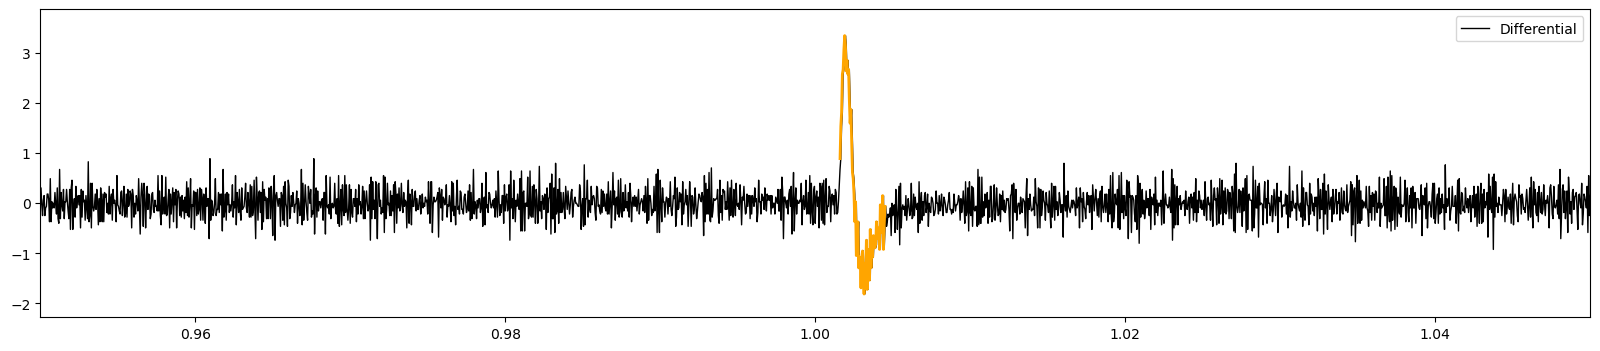

In [9]:
plt.figure(figsize = (20, 4))
plt.plot(time[:], signal, linewidth = 1, color = "black", label = "Vm")

plt.plot(time[start:end], signal[start:end], linewidth = 2, color = "orange")

plt.xlim(startTime, endTime)
plt.legend()
plt.show()


plt.figure(figsize = (20, 4))
plt.plot(time[1:], differential, linewidth = 1, c = "black", label = "Differential")

plt.plot(time[start:end], differential[start:end], linewidth = 2, color = "orange")

plt.xlim(startTime, endTime)
plt.legend()
plt.show()

## AP in all trials

In [10]:
aps = pd.read_csv(f"output/movement-s1-m1/{sample['AnimalID']}/{sample['CellName']}/action_potentials.csv")

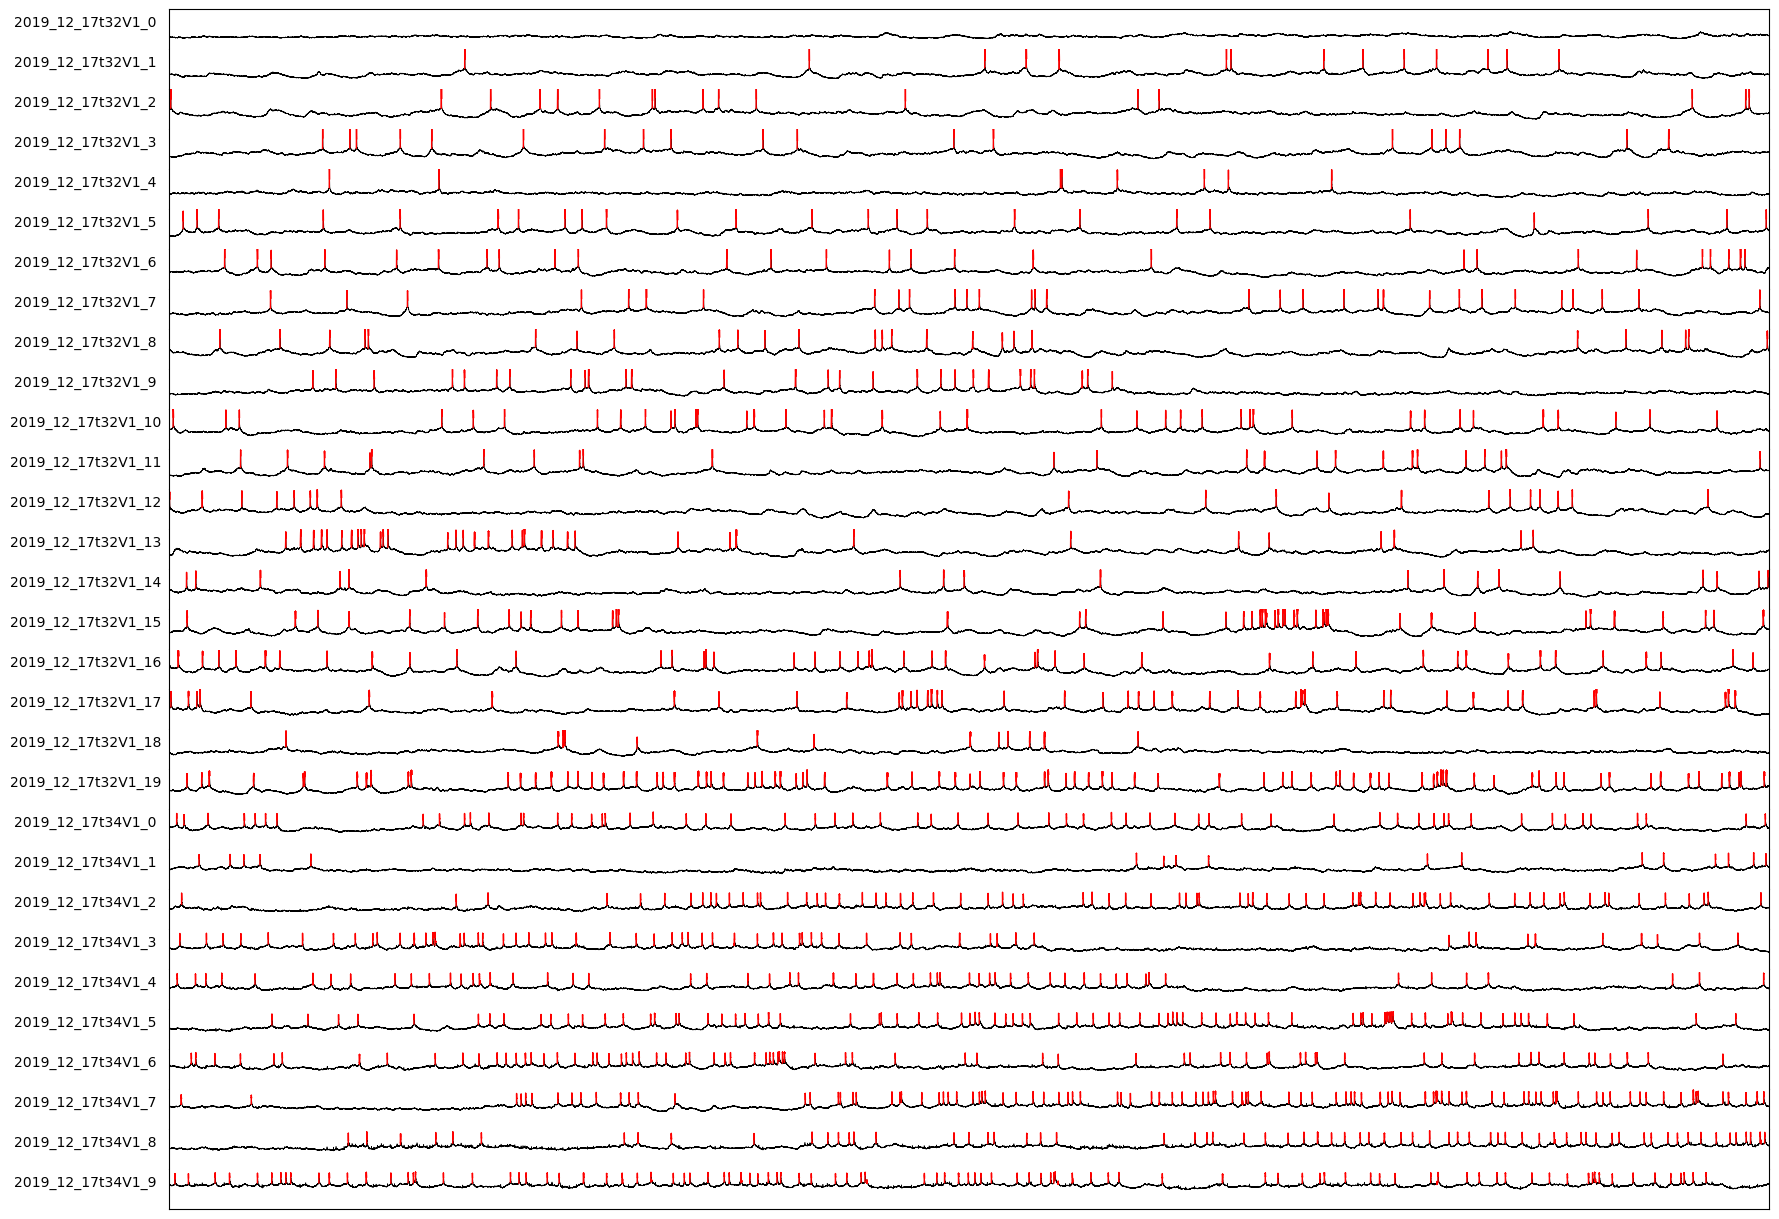

In [11]:
plot_all_events(data, channels = data.ch_names, movement = aps, limit = [-80, 0])